# Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import numpy as np

import matplotlib as mpl

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

TensorFlow 2.x selected.


In [0]:
# Load image from url
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

def download(url, target_size=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
  return img

original_img = download(url, target_size=[225, 375])

In [12]:

#Optional If you want to load images of your choice
from google.colab import files
files.upload()

image_path = 'giant-tortoise.jpg'
def download(image_path, target_size=None):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
  return img

original_img = download(image_path, target_size=[225, 375])

Saving giant-tortoise.jpg to giant-tortoise (1).jpg


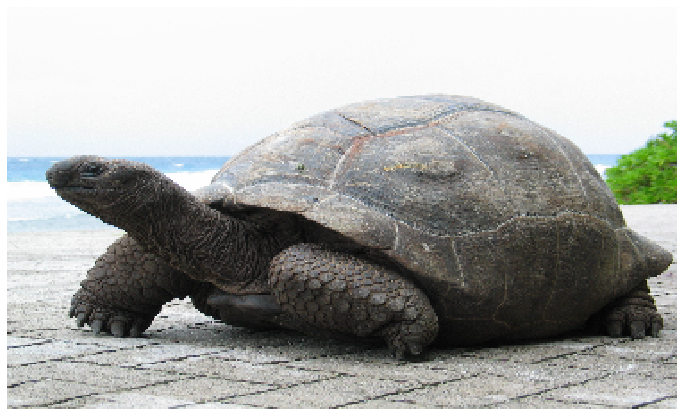

In [13]:

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)


# Display an image
def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

url = 'giant-tortoise.jpg'
# Downsizing the image makes it easier to work with.
original_img = np.array(original_img)

show(original_img)

# Prepare the feature extraction model

we will load and prepare a pre-trained image classification model. In this case 
we are going to use InceptionV3, which is similar to the model originally used in DeepDream. *N.B. any pre-trained model will work, however you will have to adjust the layer names*

In [0]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')


DeepDream main idea:


*   choose one or more layers and maximize the loss to increasingly "excite" the layers
*   Complexity of features depends on the chosen layers (lower layers correspond to simpler features, while higher layers to more sophisticated ones)

InceptionV3



*   Large architecture
*   Layers of interest are the ones where the convolutions are concatenated.
*   Whatever layer can be choses, however deeper ones will need more time to train















In [0]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


# Calculate the loss

loss is given by 


*   Sum of activations in the chosen layers
*   Is normalized at each layer, so that contribution from bigger layers does not outweigh contributions from smaller ones

N.B. normally a deep learning model is trained using Gradient descent, in this case we will use Gradient Ascent, since we want to maximize the loss


In [0]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

# Gradient Ascent

Once you have calculated losses for the chosen layers:
*   Calculate gradients w.r.t. the image
*   Add them to the original image
In this way we enhance patterns seen by the network, at each step we increasingly excite the activations of certain layers in the network.




In [0]:
@tf.function
def deepdream(model, img, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to `img`
      # `GradientTape` only watches `tf.Variable`s by default
      tape.watch(img)
      loss = calc_loss(img, model)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    
    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)

    return loss, img

In [0]:
def run_deep_dream_simple(model, img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  for step in range(steps):
    loss, img = deepdream(model, img, step_size)
    
    if step % 100 == 0:
      clear_output(wait=True)
      show(deprocess(img))
      print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  clear_output(wait=True)
  show(result)

  return result



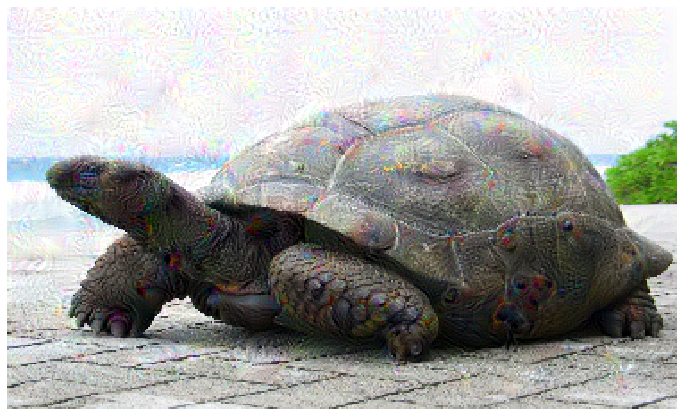

In [16]:
dream_img = run_deep_dream_simple(model=dream_model, img=original_img, steps=800, step_size=0.001)

# Scale up with octave and tiles

There are a few problems with this basic implementation


*   Output is noisy (same as in style transfer)
*   The image is low resolution.
*   Patterns appear like they're all happening at the same granularity.

One approach that solves all of these issues is to run Gradient Ascent at different scales. This allows patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

This can be done by repeating the gradient descent procedure, each time upscaling the image. 
However this approach does not **scale** well with the size of the image.

Therefore we do the following:

# Splitting up with tiles

Images are splitted into tiles and then gradient is computed for each tile, applying random shifts before image generation, prevents tile seams from appearing.

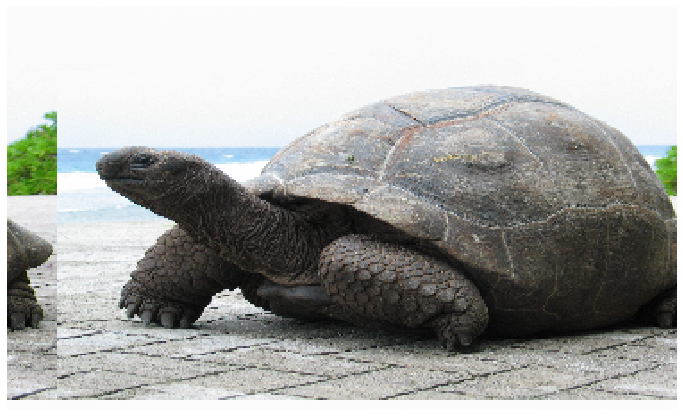

In [17]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

# Apply random roll and show result
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

Then we can define a tiled equivalent of the previously defined deepdream function

In [0]:
@tf.function

def get_tiled_gradients(model, img, tile_size = 512):
  shift_down, shift_right, img_rolled = random_roll(img, tile_size)

  # Initialize the image gradients to zero.
  gradients = tf.zeros_like(img_rolled)

  for x in tf.range(0, img_rolled.shape[0], tile_size):
    for y in tf.range(0, img_rolled.shape[1], tile_size):
      # Calculate the gradients for this tile.
      with tf.GradientTape() as tape:
        # This needs gradients relative to `img_rolled`.
        # `GradientTape` only watches `tf.Variable`s by default.
        tape.watch(img_rolled)

        # Extract a tile out of the image.
        img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
        loss = calc_loss(img_tile, model)

      # Update the image gradients for this tile.
      gradients = gradients + tape.gradient(loss, img_rolled)

  # Undo the random shift applied to the image and its gradients.
  gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

  # Normalize the gradients.
  gradients /= tf.math.reduce_std(gradients) + 1e-8 

  return gradients 

In [0]:
def run_deep_dream_with_octaves(model, img, steps_per_octave=100, step_size=0.01, 
                                num_octaves=3, octave_scale=1.3):
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  for octave in range(num_octaves):
    # Scale the image based on the octave
    if octave>0:
      new_size = tf.cast(tf.convert_to_tensor(img.shape[:2]), tf.float32)*octave_scale
      img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(model, img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  clear_output(wait=True)
  result = deprocess(img)
  show(result)

  return result

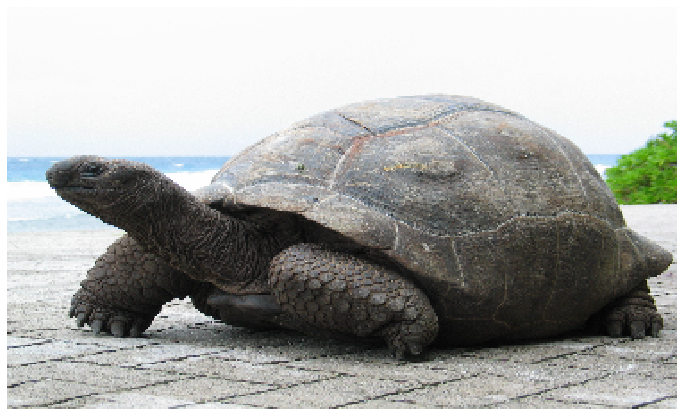

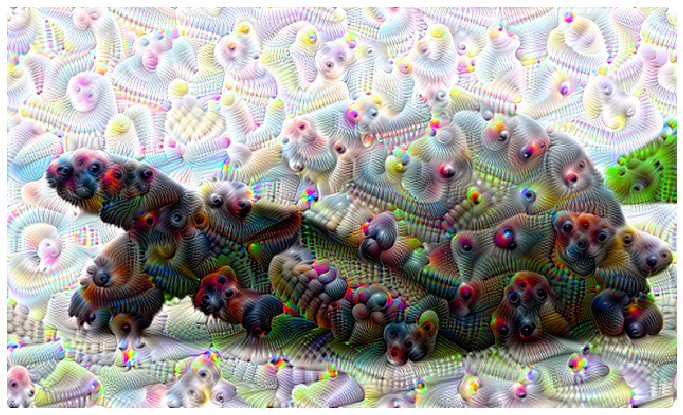

In [23]:
dream_img = run_deep_dream_with_octaves(model=dream_model, img=original_img, step_size=0.01)

clear_output()
show(original_img)
show(dream_img)